# Optical flow example
This is an example of caluclating Optical flow using Dali pipeline.

Some handy imports

In [20]:
from __future__ import print_function
from __future__ import division
import os
import numpy as np

from nvidia.dali.pipeline import Pipeline
import nvidia.dali.ops as ops
import nvidia.dali.types as types

from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec


Setting metaparamteres

In [26]:
batch_size = 1
sequence_length = 10
video_filename = "trailer.mp4"

Aquiring test data.
Warning: following snippet downloads some content onto your workstation. You might want to remember to remove it afterwards.

Functions used for Optical flow visualization.
The code comes from [Tomrunia's GitHub](https://github.com/tomrunia/OpticalFlow_Visualization "OpticalFlow_Visualization")

In [27]:
def make_colorwheel():
    '''
    Generates a color wheel for optical flow visualization as presented in:
        Baker et al. "A Database and Evaluation Methodology for Optical Flow" (ICCV, 2007)
        URL: http://vision.middlebury.edu/flow/flowEval-iccv07.pdf
    According to the C++ source code of Daniel Scharstein
    According to the Matlab source code of Deqing Sun
    '''

    RY = 15
    YG = 6
    GC = 4
    CB = 11
    BM = 13
    MR = 6

    ncols = RY + YG + GC + CB + BM + MR
    colorwheel = np.zeros((ncols, 3))
    col = 0

    # RY
    colorwheel[0:RY, 0] = 255
    colorwheel[0:RY, 1] = np.floor(255 * np.arange(0, RY) / RY)
    col = col + RY
    # YG
    colorwheel[col:col + YG, 0] = 255 - np.floor(255 * np.arange(0, YG) / YG)
    colorwheel[col:col + YG, 1] = 255
    col = col + YG
    # GC
    colorwheel[col:col + GC, 1] = 255
    colorwheel[col:col + GC, 2] = np.floor(255 * np.arange(0, GC) / GC)
    col = col + GC
    # CB
    colorwheel[col:col + CB, 1] = 255 - np.floor(255 * np.arange(CB) / CB)
    colorwheel[col:col + CB, 2] = 255
    col = col + CB
    # BM
    colorwheel[col:col + BM, 2] = 255
    colorwheel[col:col + BM, 0] = np.floor(255 * np.arange(0, BM) / BM)
    col = col + BM
    # MR
    colorwheel[col:col + MR, 2] = 255 - np.floor(255 * np.arange(MR) / MR)
    colorwheel[col:col + MR, 0] = 255
    return colorwheel


def flow_compute_color(u, v, convert_to_bgr=False):
    '''
    Applies the flow color wheel to (possibly clipped) flow components u and v.
    According to the C++ source code of Daniel Scharstein
    According to the Matlab source code of Deqing Sun
    :param u: np.ndarray, input horizontal flow
    :param v: np.ndarray, input vertical flow
    :param convert_to_bgr: bool, whether to change ordering and output BGR instead of RGB
    :return:
    '''

    flow_image = np.zeros((u.shape[0], u.shape[1], 3), np.uint8)

    colorwheel = make_colorwheel()  # shape [55x3]
    ncols = colorwheel.shape[0]

    rad = np.sqrt(np.square(u) + np.square(v))
    a = np.arctan2(-v, -u) / np.pi

    fk = (a + 1) / 2 * (ncols - 1) + 1
    k0 = np.floor(fk).astype(np.int32)
    k1 = k0 + 1
    k1[k1 == ncols] = 1
    f = fk - k0

    for i in range(colorwheel.shape[1]):
        tmp = colorwheel[:, i]
        col0 = tmp[k0] / 255.0
        col1 = tmp[k1] / 255.0
        col = (1 - f) * col0 + f * col1

        idx = (rad <= 1)
        col[idx] = 1 - rad[idx] * (1 - col[idx])
        col[~idx] = col[~idx] * 0.75  # out of range?

        # Note the 2-i => BGR instead of RGB
        ch_idx = 2 - i if convert_to_bgr else i
        flow_image[:, :, ch_idx] = np.floor(255 * col)

    return flow_image


def flow_to_color(flow_uv, clip_flow=None, convert_to_bgr=False):
    '''
    Expects a two dimensional flow image of shape [H,W,2]
    According to the C++ source code of Daniel Scharstein
    According to the Matlab source code of Deqing Sun
    :param flow_uv: np.ndarray of shape [H,W,2]
    :param clip_flow: float, maximum clipping value for flow
    :return:
    '''

    assert flow_uv.ndim == 3, 'input flow must have three dimensions'
    assert flow_uv.shape[2] == 2, 'input flow must have shape [H,W,2]'

    if clip_flow is not None:
        flow_uv = np.clip(flow_uv, 0, clip_flow)

    u = flow_uv[:, :, 0]
    v = flow_uv[:, :, 1]

    rad = np.sqrt(np.square(u) + np.square(v))
    rad_max = np.max(rad)

    epsilon = 1e-5
    u = u / (rad_max + epsilon)
    v = v / (rad_max + epsilon)

    return flow_compute_color(u, v, convert_to_bgr)

**Using Dali starts here**
Define the Pipeline. 
This example uses only one pair of frames. For advanced usage, refer to SequenceReader and VideoReader docs.

In [28]:
class OFPipeline(Pipeline):
    def __init__(self, batch_size, num_threads, device_id):
        super(OFPipeline, self).__init__(batch_size, num_threads, device_id, seed=16)

        self.input = ops.VideoReader(device="gpu", filenames=video_filename, sequence_length=sequence_length)
        self.of_op = ops.OpticalFlow(device="gpu", output_format=4)

    def define_graph(self):
        seq = self.input(name="Reader")
        of = self.of_op(seq.gpu())
        return of

Build and run

In [29]:
pipe = OFPipeline(batch_size=batch_size, num_threads=1, device_id=0)
pipe.build()
pipe_out = pipe.run()
flow_vector = pipe_out[0].as_cpu().as_array()
print(flow_vector.shape)

(1, 10, 180, 320, 2)


Visualize results

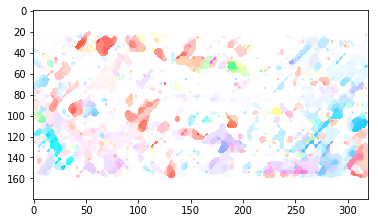

In [25]:
of_result = flow_to_color(flow_vector[0][int(sequence_length/2)])
plt.imshow(of_result)